# Initialization

In [1]:
import os
from pathlib import Path

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rc('figure', figsize=(6, 4.5))
mpl.rcParams['font.size'] = 10
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['hatch.linewidth'] = 0.5
mpl.rcParams['hatch.color'] = '0.25'

import xarray as xr
import xgcm

from scipy.special import erf
from numpy import pi as π

In [2]:
# trig functions that take degrees

def sind(x):
    return np.sin(np.deg2rad(x))

def cosd(x):
    return np.cos(np.deg2rad(x))

# Constants

In [3]:
# These should match what is specified for MOM6
ρ0 = 1035 # Boussinesq reference density
g = 9.8
Ω = 7.2921e-5
a = 6380e3 

grid_dir = '../grids'

# Make input directory

In [13]:
# Path('./INPUT').mkdir(exist_ok=True)

# Load grid

An isotropic grid has $\Delta x = \Delta y$. In spherical coordiantes, in is $\Delta \lambda \cos\vartheta = \Delta \vartheta$. We can convert this into a useful ODE by parameterizing $\vartheta$ by $j$, which takes on integer values for $q$ points and half-integer values for $h$ points. The differential equation is then

$$
    \frac{\mathrm{d}\vartheta}{\mathrm{d}j} = \Delta \lambda \cos\vartheta.
$$

The solution to this is

$$
    \vartheta = 2\arctan c_1 e^{j\Delta \lambda} - \frac{\pi}{2}.
$$

We can determine constant by requiring that $\vartheta(0) = \vartheta_s$. The result is

$$
    \vartheta = -\frac{\pi}{2} + 2\arctan \left[\tan\left(\frac{\vartheta_s}{2} + \frac{\pi}{4}\right) e^{j\Delta \lambda}\right].
$$

The number of grid points is determined by requiring $\vartheta(J) = \vartheta_n$. This gives

$$
    J \Delta \lambda = \log \tan \left(\frac{\vartheta_n}{2} + \frac{\pi}{4}\right) - \log \tan \left(\frac{\vartheta_s}{2} + \frac{\pi}{4}\right).
$$

Since $J$ must be an integer, this means that the northern boundary might not be exactly at $\vartheta_n$. If we'd rather have exact control over the domain width while being a little looser about the grid spacing, we can instead let $\Delta \lambda$ be determined by needing to fit the northern boundary:

$$
    \vartheta = -\frac{\pi}{2} + 2\arctan\left[\tan^{1-j/J}\left(\frac{\vartheta_s}{2} + \frac{\pi}{4}\right)\tan^{j/J}\left(\frac{\vartheta_n}{2} + \frac{\pi}{4}\right)\right].
$$

We'd still want to use the second to last expression above to get an guess for the correct value of $J$.

On the other hand, MOM6 has its own way of calculating the grid. We just use these formulas to get a guess for NY and run MOM6 for one step to write out the grid file. Then we just use that.

In [6]:
def get_grid_params(points_per_degree, latS=10, latN=45, len_lon=30, grid_type='isotropic'):
    NX = int(np.ceil(len_lon*points_per_degree))
    
    if grid_type == 'latlon':
        NY = int(np.ceil((latN - latS)*points_per_degree))
    elif grid_type == 'isotropic':
        tanS = np.tan(np.radians(latS)/2 + π/4)
        tanN = np.tan(np.radians(latN)/2 + π/4)

        NY = int(np.ceil(np.log(tanN/tanS)/np.radians(1/points_per_degree)))
    else:
        RuntimeError('unknown grid type')
        
    return NX, NY


The MOM6 documentation makes a big deal about `xh`, `yh`, `xq`, and `yq` being "nominal" longitudes and latitudes and recommends using `geolat` and `geolon` to get precise geographic locations. However, (at least on an isotropic Mercator grid) these two sets of coordiantes are **exactly equal** to numerical precision.

In [7]:
points_per_degree = 16

NX, NY = get_grid_params(points_per_degree=16, 
                         latS=10, latN=45, len_lon=30, 
                         grid_type='isotropic')

print(f'NX = {NX:d}, NY = {NY:d}')

grid = xr.open_dataset(os.path.join(grid_dir, f'{points_per_degree:02d}', 'ocean_geometry.nc')).rename(
    {'lath': 'yh', 'lonh': 'xh', 'latq': 'yq', 'lonq': 'xq'}
)

ic = xr.Dataset()
for fld in ('yh', 'xh', 'yq', 'xq'):
    ic.coords[fld] = grid[fld]
ic

NX = 480, NY = 648


<xarray.Dataset>
Dimensions:  (yh: 648, xh: 480, yq: 649, xq: 481)
Coordinates:
  * yh       (yh) float64 10.03 10.09 10.15 10.22 ... 44.88 44.93 44.97 45.01
  * xh       (xh) float64 0.03125 0.09375 0.1562 0.2187 ... 29.84 29.91 29.97
  * yq       (yq) float64 10.0 10.06 10.12 10.18 ... 44.9 44.95 44.99 45.04
  * xq       (xq) float64 0.0 0.0625 0.125 0.1875 ... 29.81 29.87 29.94 30.0
Data variables:
    *empty*

The northern boundary isn't quite at 45, but it's close enough.

In [8]:
grid.yq.isel(yq=-1)

<xarray.DataArray 'yq' ()>
array(45.03687997)
Coordinates:
    yq       float64 45.04
Attributes:
    long_name:       Latitude
    units:           degrees_north
    cartesian_axis:  Y

Plot of grid spacing

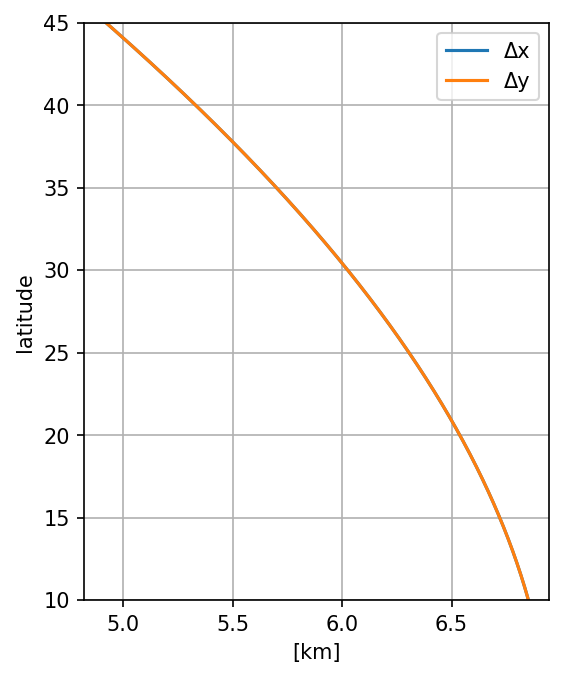

In [9]:
fig, ax = plt.subplots(figsize=(4,5))

ax.plot(grid.dxT.isel(xh=0)/1e3, grid.yh, label='Δx')
ax.plot(grid.dyT.isel(xh=0)/1e3, grid.yh, label='Δy')
ax.legend()
ax.set_ylim(10, 45)
ax.set_xlabel('[km]')
ax.set_ylabel('latitude')
ax.grid()

# Layer configuration

We probably ought to pick the layer configurations to be close to the same as zonal jet case. This would give us reduced gravities of $g'_1 = 0.0159$ m s$^{-2}$ and $g'_2 = 0.00223$ m s$^{-2}$. The thicknesses of the surface, intermediate, and deep layers are $H_1 = 700$ m, $H_2 = 1300$ m, and $H_3 = 3000$ m. Hitting these depths might take a little fiddling, since we really only specify the initial volume of each density class and have to wait to see what the actual arrangement of thicknesses works out to be. Trying to get a guess from an analytic solution might be more trouble than it's worth.

An alternative approach would be to specify the depths at the southern boundary and use weak relaxation to keep the layer depths approximately correct. We'll just go with the first approach for now.

In [196]:
gprime = np.array([
    g,
    0.0159,
    0.00223
])

zl = np.cumsum(gprime*ρ0/g)
zi = np.hstack(([1.5*zl[0] - 0.5*zl[1]],
                (zl[:-1] + zl[1:])/2,
                [1.5*zl[-1] - 0.5*zl[-2]]
          ))

ic.coords['zl'] = (['zl'], zl, {'long_name': 'Layer Target Potential Density', 'units': 'kg m-3', 'cartesian_axis': 'Z', 'positive': 'up'})
ic.coords['zi'] = (['zi'], zi, {'long_name': 'Interface Target Potential Density', 'units': 'kg m-3', 'cartesian_axis': 'Z', 'positive': 'up'})

# We'd like the thickness to be 
# H = np.array([
#     700,
#     1300,
#     3000
# ])
# in the equivalent of the Sargasso Sea. Typically, the eastern boundary depth of the lower interface remains the same and the upper layer a bit shallower. 
# We might expect that the lower interface doesn't move very much, so we keep that at -2000. 
Hmax = 5000

H = np.array([
    500,
    1500,
    3000,
], dtype=float)

eta = np.hstack([0, -np.cumsum(H)])

ic['eta'] = (['zi'], eta, {'long_name': 'Initial depth of interfaces', 'units': 'm'})

ic

<xarray.Dataset>
Dimensions:  (yh: 648, xh: 480, yq: 649, xq: 481, zl: 3, zi: 4)
Coordinates:
  * yh       (yh) float64 10.03 10.09 10.15 10.22 ... 44.88 44.93 44.97 45.01
  * xh       (xh) float64 0.03125 0.09375 0.1562 0.2187 ... 29.84 29.91 29.97
  * yq       (yq) float64 10.0 10.06 10.12 10.18 ... 44.9 44.95 44.99 45.04
  * xq       (xq) float64 0.0 0.0625 0.125 0.1875 ... 29.81 29.87 29.94 30.0
  * zl       (zl) float64 1.035e+03 1.037e+03 1.037e+03
  * zi       (zi) float64 1.034e+03 1.036e+03 1.037e+03 1.037e+03
Data variables:
    eta      (zi) float64 0.0 -500.0 -2e+03 -5e+03
    depth    (yh, xh) float64 100.5 100.8 101.1 101.7 ... 100.0 100.0 100.0
    taux     (yh, xq) float64 -0.1207 -0.1207 -0.1207 ... -0.000182 -0.000182
    tauy     (yq, xh) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [11]:
grid_op = xgcm.Grid(ic, periodic=False, boundary='fill', fill_value=0, coords={
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
    'Z': {'center': 'zl', 'outer': 'zi'},

})
grid_op

<xgcm.Grid>
X Axis (not periodic, boundary='fill'):
  * center   xh --> outer
  * outer    xq --> center
Y Axis (not periodic, boundary='fill'):
  * center   yh --> outer
  * outer    yq --> center
Z Axis (not periodic, boundary='fill'):
  * center   zl --> outer
  * outer    zi --> center

# Topography - Erf-like shelves on eastern, northern, and western boundaries

If the shelves are constant width in degrees, a parcel moving purely north will experience no vortex stretching or compression.

(0.0, 30.0)

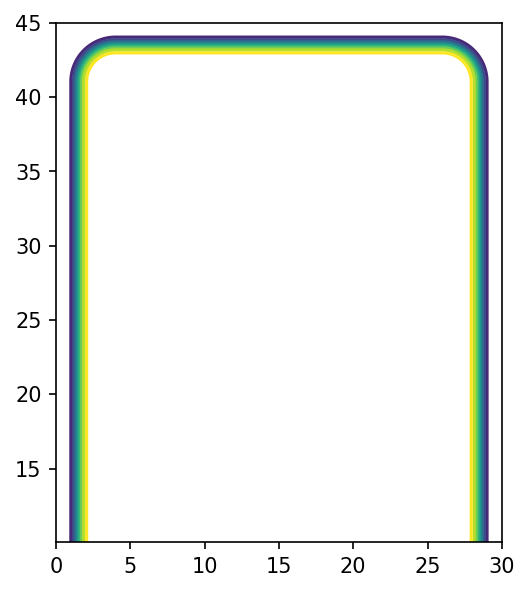

In [176]:
constant_width_in_degrees = True
Hshelf = 100
Hmax = 5000

if constant_width_in_degrees == True:
    Lshelf = 1
    Lslope = 1
    corner_radius = 4**2

    def H0(x):
        H = Hmax - 0.5*(Hmax - Hshelf)*(1 - erf(np.sqrt(π)*((x - Lshelf)/Lslope - 0.5)))
        return xr.where(H > Hshelf, H, Hshelf)

    # this is a weird way to get around the fact that np.minimum doesn't work on dataarrays
    H = xr.concat((H0(grid.yq[-1] - grid.yh) + 0*grid.xh, H0(grid.xh) + 0*grid.yh, H0(grid.xq[-1]-grid.xh) + 0*grid.yh), 'dummy').min('dummy')

    # fix up the corners
    # northwest corner
    x0 = grid.xq[ 0] + np.sqrt(corner_radius)
    y0 = grid.yq[-1] - np.sqrt(corner_radius)

    R = np.sqrt((grid.yh - y0)**2 + (grid.xh - x0)**2)
    H = xr.where((grid.yh >= y0) & (grid.xh <= x0), H0(x0 - R), H)

    # northeast corner
    x0 = grid.xq[-1] - np.sqrt(corner_radius)
    y0 = grid.yq[-1] - np.sqrt(corner_radius)

    R = np.sqrt((grid.yh - y0)**2 + (grid.xh - x0)**2)
    H = xr.where((grid.yh >= y0) & (grid.xh >= x0), H0(grid.xq[-1] - x0 - R), H)

plt.contour(grid.xh, grid.yh, H, np.arange(100, 5000, 500))
plt.gca().set_aspect(1)
plt.xlim(0, 30)


In [189]:
ic['depth'] = H
ic.depth.attrs = {'long_name': 'Ocean Depth', 'units': 'm'}

# topog.to_netcdf('INPUT/topog_degrees.nc')

ic

<xarray.Dataset>
Dimensions:  (yh: 648, xh: 480, yq: 649, xq: 481, zl: 3, zi: 4)
Coordinates:
  * yh       (yh) float64 10.03 10.09 10.15 10.22 ... 44.88 44.93 44.97 45.01
  * xh       (xh) float64 0.03125 0.09375 0.1562 0.2187 ... 29.84 29.91 29.97
  * yq       (yq) float64 10.0 10.06 10.12 10.18 ... 44.9 44.95 44.99 45.04
  * xq       (xq) float64 0.0 0.0625 0.125 0.1875 ... 29.81 29.87 29.94 30.0
  * zl       (zl) float64 1.035e+03 1.037e+03 1.037e+03
  * zi       (zi) float64 1.034e+03 1.036e+03 1.037e+03 1.037e+03
Data variables:
    eta      (zi) float64 0.0 -500.0 -2e+03 -5.001e+03
    depth    (yh, xh) float64 100.5 100.8 101.1 101.7 ... 100.0 100.0 100.0
    taux     (yh, xq) float64 -0.1207 -0.1207 -0.1207 ... -0.000182 -0.000182
    tauy     (yq, xh) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

# Wind forcing

## Simple curl

The wind forcing is the same as in the Parsons-Veronis notebook.

In [190]:
T0 = 20e6 # transport

lonE = 30 # eastern boundary
λe = np.deg2rad(lonE)

V0 = T0/(a*λe*cosd(25))

# def tau(y, derivative=False):
#     θ = np.radians(y)
#     if derivative:
#         return -(V0*Ω/(1386*np.cos(θ)**2))*np.piecewise(θ, 
#                     [θ > np.deg2rad(15), θ <= np.deg2rad(15)],
#                     [lambda θ: 315*np.sin(12*θ + π/4) + 994*np.sin(10*θ + π/4) + 1067*np.sin(8*θ + π/4) + 396*np.sin(6*θ + π/4) + 36*np.sin(θ), 
#                      lambda θ: (190 + 81*np.sqrt(3))*np.sin(θ)])
#     else:
#         return (V0*Ω/(1386*np.cos(θ)))*np.piecewise(θ, 
#                     [θ > np.deg2rad(15), θ <= np.deg2rad(15)],
#                     [lambda θ: 63*np.cos(11*θ + π/4) + 154*np.cos(9*θ + π/4) + 99*np.cos(7*θ + π/4) - 36, 
#                      lambda θ: -190 - 81*np.sqrt(3) ])


def tau(y, derivative=False):
    θ = np.radians(y)
    if derivative:
        return -(ρ0*V0*Ω/(1386*np.cos(θ)**2))*xr.where(y > 15, 
                     315*np.sin(12*θ + π/4) + 994*np.sin(10*θ + π/4) + 1067*np.sin(8*θ + π/4) + 396*np.sin(6*θ + π/4) + 36*np.sin(θ), 
                     (190 + 81*np.sqrt(3))*np.sin(θ))
    else:
        return (ρ0*V0*Ω/(1386*np.cos(θ)))*xr.where(y > 15, 
                    63*np.cos(11*θ + π/4) + 154*np.cos(9*θ + π/4) + 99*np.cos(7*θ + π/4) - 36, 
                    -190 - 81*np.sqrt(3))


ic['taux'] = tau(grid.yh) + 0*grid.xq
ic['tauy'] = 0*grid.yq + 0*grid.xh
ic


<xarray.Dataset>
Dimensions:  (yh: 648, xh: 480, yq: 649, xq: 481, zl: 3, zi: 4)
Coordinates:
  * yh       (yh) float64 10.03 10.09 10.15 10.22 ... 44.88 44.93 44.97 45.01
  * xh       (xh) float64 0.03125 0.09375 0.1562 0.2187 ... 29.84 29.91 29.97
  * yq       (yq) float64 10.0 10.06 10.12 10.18 ... 44.9 44.95 44.99 45.04
  * xq       (xq) float64 0.0 0.0625 0.125 0.1875 ... 29.81 29.87 29.94 30.0
  * zl       (zl) float64 1.035e+03 1.037e+03 1.037e+03
  * zi       (zi) float64 1.034e+03 1.036e+03 1.037e+03 1.037e+03
Data variables:
    eta      (zi) float64 0.0 -500.0 -2e+03 -5.001e+03
    depth    (yh, xh) float64 100.5 100.8 101.1 101.7 ... 100.0 100.0 100.0
    taux     (yh, xq) float64 -0.1207 -0.1207 -0.1207 ... -0.000182 -0.000182
    tauy     (yq, xh) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [184]:
f = 2*Ω*sind(grid.yh)
fq = 2*Ω*sind(grid.yq)
β = 2*Ω*cosd(grid.yh)/a
βq = 2*Ω*cosd(grid.yq)/a
Lxh = grid.dxT.sum('xh')
Lxq = grid.dxBu.sum('xq')


# net Ekman transport
Vek = -1e-6*(ic.taux/f*grid.dxCu/ρ0).sum('xq')

# # Sverdrup transport
wsc = -(grid_op.diff(ic.taux*grid.dxCu, 'Y', boundary='extend')/grid.Aq)
Vsv = 1e-6*(wsc/βq/ρ0*grid.dxBu).sum('xq')
# Vsv = (Lxq/βq)[1:-1]*wsc

# net geostrophic transport
wEk = -(grid_op.diff(ic.taux*grid.dxCu/f/ρ0, 'Y', boundary='extend')/grid.Aq)
# wEk = -np.diff(dxh*tau(np.deg2rad(yh))/f)/Aq
Vg = 1e-6*(fq*wEk/βq*grid.dxBu).sum('xq')

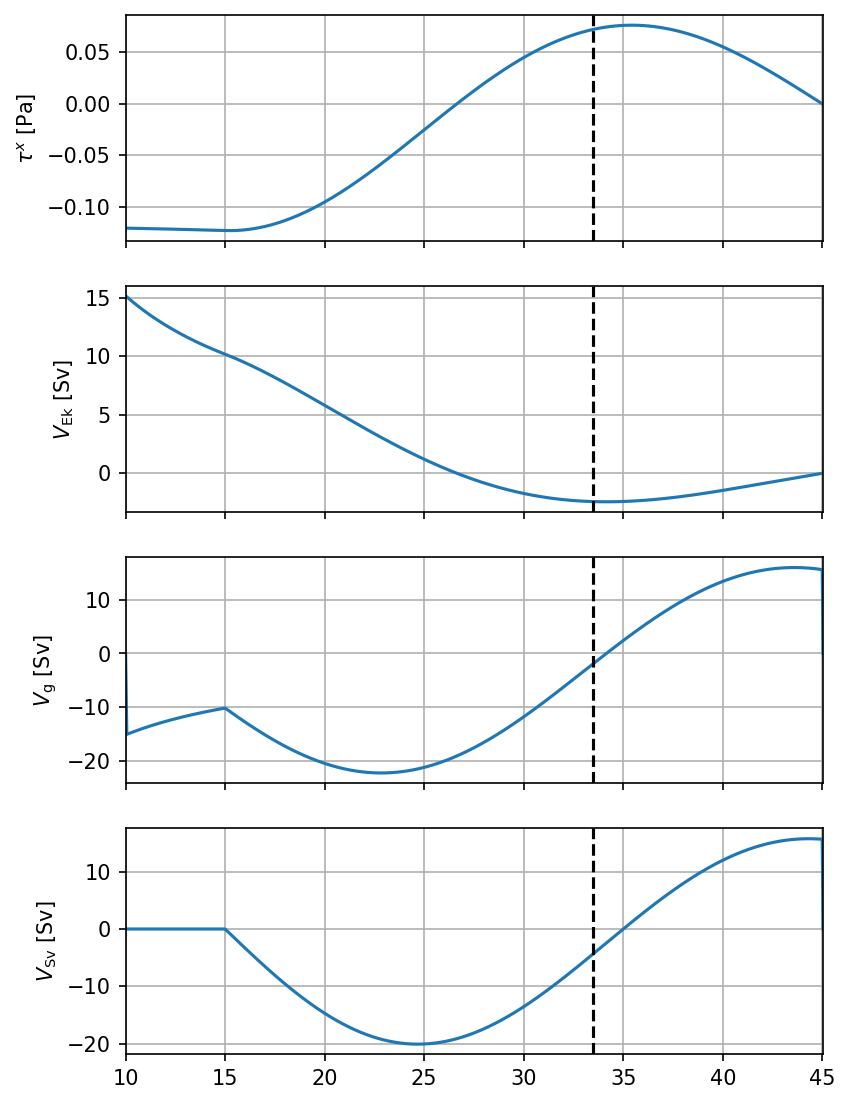

In [185]:
fig, axs = plt.subplots(nrows=4, sharex=True, figsize=(6, 9))

ax = axs[0]
ax.plot(ic.yh, ic.taux.isel(xq=0))
ax.set_ylabel(r'$\tau^x$ [Pa]')

ax = axs[1]
ax.plot(ic.yh, Vek)
ax.set_ylabel(r'$V_\mathrm{Ek}$ [Sv]')

ax = axs[2]
ax.plot(ic.yq, Vg, '-')
ax.set_ylabel(r'$V_\mathrm{g}$ [Sv]')

ax = axs[3]
ax.plot(ic.yq, Vsv)
ax.set_ylabel(r'$V_\mathrm{Sv}$ [Sv]')

ax.set_xlim([grid.yq[0], grid.yq[-1]])

for ax in axs:
    ax.axvline(33.5, ls='--', color='k')
    ax.grid()

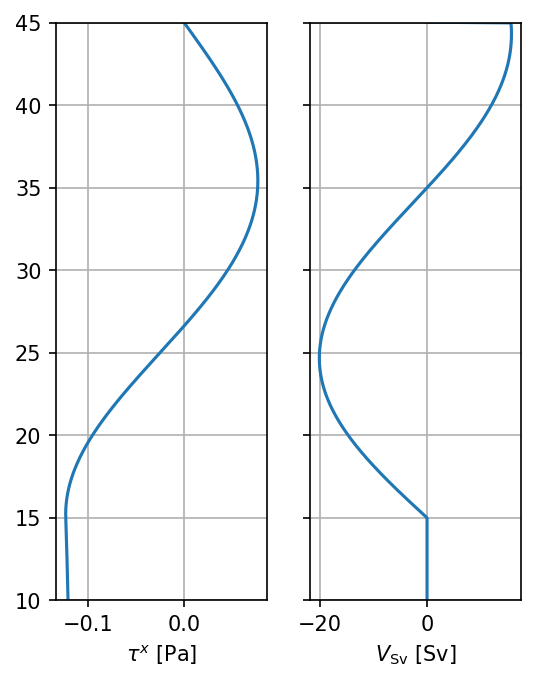

In [120]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(4, 5))

ax = axs[0]
ax.plot(ic.taux.isel(xq=0), ic.yh)
ax.set_xlabel(r'$\tau^x$ [Pa]')

ax = axs[1]
ax.plot(Vsv, ic.yq)
ax.set_xlabel(r'$V_\mathrm{Sv}$ [Sv]')

ax.set_ylim([10, 45])

for ax in axs:
    # ax.axhline(33.5, ls='--', color='k')
    ax.grid()
    
fig.savefig('wind.pdf', bbox_inches='tight')

In [16]:
# MOM6 expects xq and yq to be missing the last point
forcing = xr.Dataset(coords={
    'yh': (['yh'], yh), 
    'xh': (['xh'], xh),
    'yq': (['yq'], yq[:-1]), 
    'xq': (['xq'], xq[:-1]),
})

forcing['STRESS_X'] = (['yh', 'xq'], taux[:,:-1], {'long_name': 'Zonal Momentum Flux', 'units': 'Pa'})
forcing['STRESS_Y'] = (['yq', 'xh'], tauy[:-1,:], {'long_name': 'Meridional Momentum Flux', 'units': 'Pa'})

forcing.to_netcdf('INPUT/forcing.nc')

forcing

<xarray.Dataset>
Dimensions:   (yh: 321, xh: 240, yq: 321, xq: 240)
Coordinates:
  * yh        (yh) float64 10.06 10.18 10.31 10.43 ... 44.46 44.55 44.64 44.73
  * xh        (xh) float64 0.0625 0.1875 0.3125 0.4375 ... 29.69 29.81 29.94
  * yq        (yq) float64 10.0 10.12 10.25 10.37 ... 44.42 44.5 44.59 44.68
  * xq        (xq) float64 0.0 0.125 0.25 0.375 0.5 ... 29.5 29.62 29.75 29.88
Data variables:
    STRESS_X  (yh, xq) float64 -0.1208 -0.1208 -0.1208 ... 0.003364 0.003364
    STRESS_Y  (yq, xh) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0